In [1]:
import sys
import stlearn as st
st.settings.set_figure_params(dpi=300)
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
file = Path("../stimage").resolve()
parent= file.parent
sys.path.append(str(parent))
from PIL import Image
from stimage._utils import gene_plot, Read10X, ReadOldST, tiling
from stimage._model import CNN_NB_multiple_genes, negative_binomial_layer, negative_binomial_loss
from stimage._data_generator import DataGenerator, DataGenerator_LSTM_one_output
import tensorflow as tf
import seaborn as sns
sns.set_style("white")
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
# import geopandas as gpd
from sklearn.neighbors import KDTree
from anndata import read_h5ad
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import umap

In [2]:
import matplotlib.pyplot as plt
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import splot
from splot.esda import moran_scatterplot, lisa_cluster
from esda.moran import Moran, Moran_Local
from esda.moran import Moran_BV, Moran_Local_BV
from splot.esda import plot_moran_bv_simulation, plot_moran_bv, plot_local_autocorrelation

In [3]:
from matplotlib import pyplot as plt
import numpy as np
from typing import Optional, Union
from anndata import AnnData


def BB_plot_grey(
    adata: AnnData,
    library_id: str = None,
    name: str = None,
    data_alpha: float = 0.8,
    tissue_alpha: float = 1.0,
    cmap: str = "Spectral_r",
    spot_size: tuple = (5, 30),
    ob1: str = None,
    ob2: str = None,
    ob3: str = None,
    col: int = None,
    show_color_bar: bool = True,
    show_size_legend: bool = True,
    show_axis: bool = False,
    cropped: bool = True,
    margin: int = 100,
    dpi: int = 150,
    output: str = None,
) -> Optional[AnnData]:
    
    ob_3 = adata.obsm[ob3][:,col]
    adata_ = adata[ob_3>0].copy()
    adata_0 = adata[ob_3<=0].copy()
    imagecol = adata_.obs["imagecol"]
    imagerow = adata_.obs["imagerow"]
    from sklearn.preprocessing import MinMaxScaler
    
    ob_1 = adata_.obsm[ob1][:,col]
    scaler = MinMaxScaler(feature_range=spot_size)
    ob1_size = scaler.fit_transform(ob_1.reshape(-1, 1))
    ob_2 = adata_.obsm[ob2][:,col]
#     print(ob_1)
#     print(ob_2)
    # plt.rcParams['figure.dpi'] = dpi

    # Option for turning off showing figure
    plt.ioff()

    # Initialize matplotlib
    fig, a = plt.subplots()

    vmin = min(ob_2)
    vmax = max(ob_2)
    # Plot scatter plot based on pixel of spots
    plot = a.scatter(
        adata_.obs["imagecol"],
        adata_.obs["imagerow"],
        edgecolor="none",
        alpha=data_alpha,
        s=ob1_size,
        marker="o",
        vmin=vmin,
        vmax=vmax,
        cmap=plt.get_cmap(cmap),
        c=ob_2,
    )

    if show_color_bar:
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        axins = inset_axes(a,
                   width="100%",
                   height="100%",
                   loc='upper left',
                   bbox_to_anchor=(1.0, 0.73, 0.05, 0.35),
                   bbox_transform=a.transAxes,
                   borderpad=4.3,
                   )
        cb = plt.colorbar(plot, cax=axins)
        cb.ax.set_xlabel(ob2, fontsize=10)
        cb.ax.xaxis.set_label_coords(0.98, 1.20)
        cb.outline.set_visible(False)

    if show_size_legend:
        size_min, size_max = spot_size
        markers = [size_min, size_min + 1 / 3 * (size_max - size_min),
                   size_min + 2 / 3 * (size_max - size_min), size_max]
        legend_markers = [plt.scatter([], [], s=i, c="grey") for i in markers]
        labels = ["{:.2f}".format(float((scaler.inverse_transform(np.array(i).reshape(1, 1)))))
                  for i in markers]
        a.legend(handles=legend_markers, labels=labels, loc='lower left', bbox_to_anchor=(1, 0.05),
                   scatterpoints=1, frameon=False, title=ob1)

    if not show_axis:
        a.axis("off")
    if library_id is None:
        library_id = list(adata.uns["spatial"].keys())[0]

    image = adata.uns["spatial"][library_id]["images"][
        adata.uns["spatial"][library_id]["use_quality"]
    ]
    if len(adata_0) > 0:
        a.scatter(
            adata_0.obs["imagecol"],
            adata_0.obs["imagerow"],
            edgecolor="none",
            alpha=data_alpha,
            s=5,
            marker="o",
            color="white",
        )
    
    # Overlay the tissue image
    a.imshow(
        image,
        alpha=tissue_alpha,
        zorder=-1,
    )

    if cropped:
        a.set_xlim(imagecol.min() - margin, imagecol.max() + margin)

        a.set_ylim(imagerow.min() - margin, imagerow.max() + margin)

        a.set_ylim(a.get_ylim()[::-1])
        # plt.gca().invert_yaxis()

    # fig.tight_layout()
    if output is not None:
        fig.savefig(output + "/" + name, dpi=dpi, bbox_inches="tight", pad_inches=0)

    plt.show()




In [4]:
from scipy import stats

def plot_correlation(df, attr_1, attr_2):
    r = stats.pearsonr(df[attr_1], 
                       df[attr_2])[0] **2

    g = sns.lmplot(data=df,
        x=attr_1, y=attr_2,
        height=5, legend=True
    )
    # g.set(ylim=(0, 360), xlim=(0,360))

    g.set_axis_labels(attr_1, attr_2)
    plt.annotate(r'$R^2:{0:.2f}$'.format(r),
                (max(df[attr_1])*0.9, max(df[attr_2])*0.9))
    return g


def calculate_correlation(attr_1, attr_2):
    r = stats.pearsonr(attr_1, 
                       attr_2)[0]
    return r

def calculate_correlation_2(attr_1, attr_2):
    r = stats.spearmanr(attr_1, 
                       attr_2)[0]
    return r

In [5]:

DATA_PATH = Path("/clusterdata/uqxtan9/Xiao/dataset_breast_cancer_9visium")

OUT_PATH = Path("/clusterdata/uqxtan9/Xiao/STimage_plot")
OUT_PATH.mkdir(parents=True, exist_ok=True)

In [6]:
adata_all = read_h5ad(DATA_PATH / "all_adata.h5ad")

In [7]:
adata_all.obs["tile_path"] = adata_all.obs.tile_path.map(lambda x:x.replace("/clusterdata/uqxtan9/Xiao/breast_cancer_9visium/",
                                               "/clusterdata/uqxtan9/Xiao/dataset_breast_cancer_9visium/"))

In [8]:
gene_list=["COX6C","TTLL12", "PABPC1", "GNAS", "HSP90AB1", 
           "TFF3", "ATP1A1", "B2M", "FASN", "SPARC", "CD74", "CD63", "CD24", "CD81"]
gene_list

In [9]:
adata_all.obs["library_id"].unique()

In [10]:
for i, gene in enumerate(gene_list): 
    print(gene)
    adata = adata_all[adata_all.obs["library_id"] == "1142243F"]
    gene_plot(adata, 
              genes=gene,
              output=str(OUT_PATH),
              library_id="1142243F",
              name="1142243F_GC_{}.png".format(gene)
             )

In [11]:
adata_all_train_valid = adata_all[adata_all.obs["library_id"].isin(
    adata_all.obs.library_id.cat.remove_categories(["FFPE", "1160920F"]).unique())]

In [12]:
adata_all[adata_all.obs["library_id"].isin(
    adata_all.obs.library_id.cat.remove_categories(["FFPE", "1160920F"]).unique())].obs.sample(frac=0.7, random_state=1).index

In [13]:
n_genes = len(gene_list)
training_index = adata_all_train_valid.obs.sample(frac=0.7, random_state=1).index
training_dataset = adata_all_train_valid[training_index,].copy()

valid_index = adata_all_train_valid.obs.index.isin(training_index)
valid_dataset = adata_all_train_valid[~valid_index,].copy()

test_index = adata_all.obs.library_id == "FFPE"
test_dataset_1 = adata_all[test_index,].copy()

test_index = adata_all.obs.library_id == "1160920F"
test_dataset_2 = adata_all[test_index,].copy()

In [14]:
train_gen = tf.data.Dataset.from_generator(
            lambda:DataGenerator(adata=training_dataset, 
                          genes=gene_list, aug=False),
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
train_gen_ = train_gen.shuffle(buffer_size=500).batch(128).repeat(3).cache().prefetch(tf.data.experimental.AUTOTUNE)
valid_gen = tf.data.Dataset.from_generator(
            lambda:DataGenerator(adata=valid_dataset, 
                          genes=gene_list), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
valid_gen_ = valid_gen.shuffle(buffer_size=500).batch(128).repeat(3).cache().prefetch(tf.data.experimental.AUTOTUNE)
test_gen_1 = tf.data.Dataset.from_generator(
            lambda:DataGenerator(adata=test_dataset_1, 
                          genes=gene_list), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
test_gen__1 = test_gen_1.batch(1)
test_gen_2 = tf.data.Dataset.from_generator(
            lambda:DataGenerator(adata=test_dataset_2, 
                          genes=gene_list), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
test_gen__2 = test_gen_2.batch(1)

In [15]:
K.clear_session()
model = CNN_NB_multiple_genes((299, 299, 3), n_genes)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,
                                            restore_best_weights=False)

In [ ]:
train_history = model.fit(train_gen_,
                          epochs=100,
                          validation_data=valid_gen_,
                          callbacks=[callback]
                          )

In [16]:
model.load_weights("./CNN_NB_9visium_14_markers_v2.h5")

In [17]:
# model.summary()

In [18]:
latent_layer = Model(inputs=model.input, outputs=model.get_layer("global_average_pooling2d").output)

In [19]:
test_predictions = model.predict(test_gen__1)
from scipy.stats import nbinom
y_preds = []
for i in range(n_genes):
    n = test_predictions[i][:, 0]
    p = test_predictions[i][:, 1]
    y_pred = nbinom.mean(n, p)
    y_preds.append(y_pred)
test_dataset_1.obsm["predicted_gene"] = np.array(y_preds).transpose()

In [20]:
test_predictions = model.predict(test_gen__2)
from scipy.stats import nbinom
y_preds = []
for i in range(n_genes):
    n = test_predictions[i][:, 0]
    p = test_predictions[i][:, 1]
    y_pred = nbinom.mean(n, p)
    y_preds.append(y_pred)
test_dataset_2.obsm["predicted_gene"] = np.array(y_preds).transpose()

In [21]:
test_predictions = model.predict(test_gen__1)
test_dataset_1.obsm["latent_features"] = latent_layer.predict(test_gen__1)
from scipy.stats import nbinom
y_preds = []
y_stds = []
y_intervals_low = []
y_intervals_high = []
n_list=[]
p_list=[]
for i in range(n_genes):
    n = test_predictions[i][:, 0]
    p = test_predictions[i][:, 1]
    y_pred = nbinom.mean(n, p)
    y_preds.append(y_pred)
    y_std = nbinom.std(n, p)
    y_stds.append(y_std)
    y_interval_low, y_interval_high = nbinom.interval(0.80,n, p)
    y_intervals_low.append(y_interval_low)
    y_intervals_high.append(y_interval_high)
    n_list.append(n)
    p_list.append(p)
test_dataset_1.obsm["n"] = np.array(n_list).transpose()
test_dataset_1.obsm["p"] = np.array(p_list).transpose()
test_dataset_1.obsm["predicted_gene"] = np.array(y_preds).transpose()
test_dataset_1.obsm["predicted_gene_std"] = np.array(y_stds).transpose()
test_dataset_1.obsm["predicted_gene_interval_low"] = np.array(y_intervals_low).transpose()
test_dataset_1.obsm["predicted_gene_interval_high"] = np.array(y_intervals_high).transpose()

In [22]:
test_predictions = model.predict(test_gen__2)
test_dataset_2.obsm["latent_features"] = latent_layer.predict(test_gen__2)
from scipy.stats import nbinom
y_preds = []
y_stds = []
y_intervals_low = []
y_intervals_high = []
n_list=[]
p_list=[]
for i in range(n_genes):
    n = test_predictions[i][:, 0]
    p = test_predictions[i][:, 1]
    y_pred = nbinom.mean(n, p)
    y_preds.append(y_pred)
    y_std = nbinom.std(n, p)
    y_stds.append(y_std)
    y_interval_low, y_interval_high = nbinom.interval(0.80,n, p)
    y_intervals_low.append(y_interval_low)
    y_intervals_high.append(y_interval_high)
    n_list.append(n)
    p_list.append(p)
test_dataset_2.obsm["n"] = np.array(n_list).transpose()
test_dataset_2.obsm["p"] = np.array(p_list).transpose()
test_dataset_2.obsm["predicted_gene"] = np.array(y_preds).transpose()
test_dataset_2.obsm["predicted_gene_std"] = np.array(y_stds).transpose()
test_dataset_2.obsm["predicted_gene_interval_low"] = np.array(y_intervals_low).transpose()
test_dataset_2.obsm["predicted_gene_interval_high"] = np.array(y_intervals_high).transpose()

In [23]:
OUT_PATH = Path("/clusterdata/uqxtan9/Xiao/STimage/development/CNN_NB_std")

In [37]:
test_dataset_1_ = test_dataset_1[:,gene_list].copy()
test_dataset_1_.X = test_dataset_1_.obsm["predicted_gene"]

In [38]:
test_dataset_2_ = test_dataset_2[:,gene_list].copy()
test_dataset_2_.X = test_dataset_2_.obsm["predicted_gene"]

In [47]:
pred_adata = test_dataset_1_
test_dataset = test_dataset_1
df = pd.DataFrame()

for gene in pred_adata.var_names:
    cor_val = calculate_correlation(pred_adata.to_df().loc[:,gene], test_dataset.to_df().loc[:,gene])
    df = df.append(pd.Series([gene, cor_val, "FFPE"], index=["Gene", "Pearson correlation", "Slide"]),
                  ignore_index=True)

pred_adata = test_dataset_2_
test_dataset = test_dataset_2

for gene in pred_adata.var_names:
    cor_val = calculate_correlation(pred_adata.to_df().loc[:,gene], test_dataset.to_df().loc[:,gene])
    df = df.append(pd.Series([gene, cor_val, "1160920F"], index=["Gene", "Pearson correlation", "Slide"]),
                  ignore_index=True)

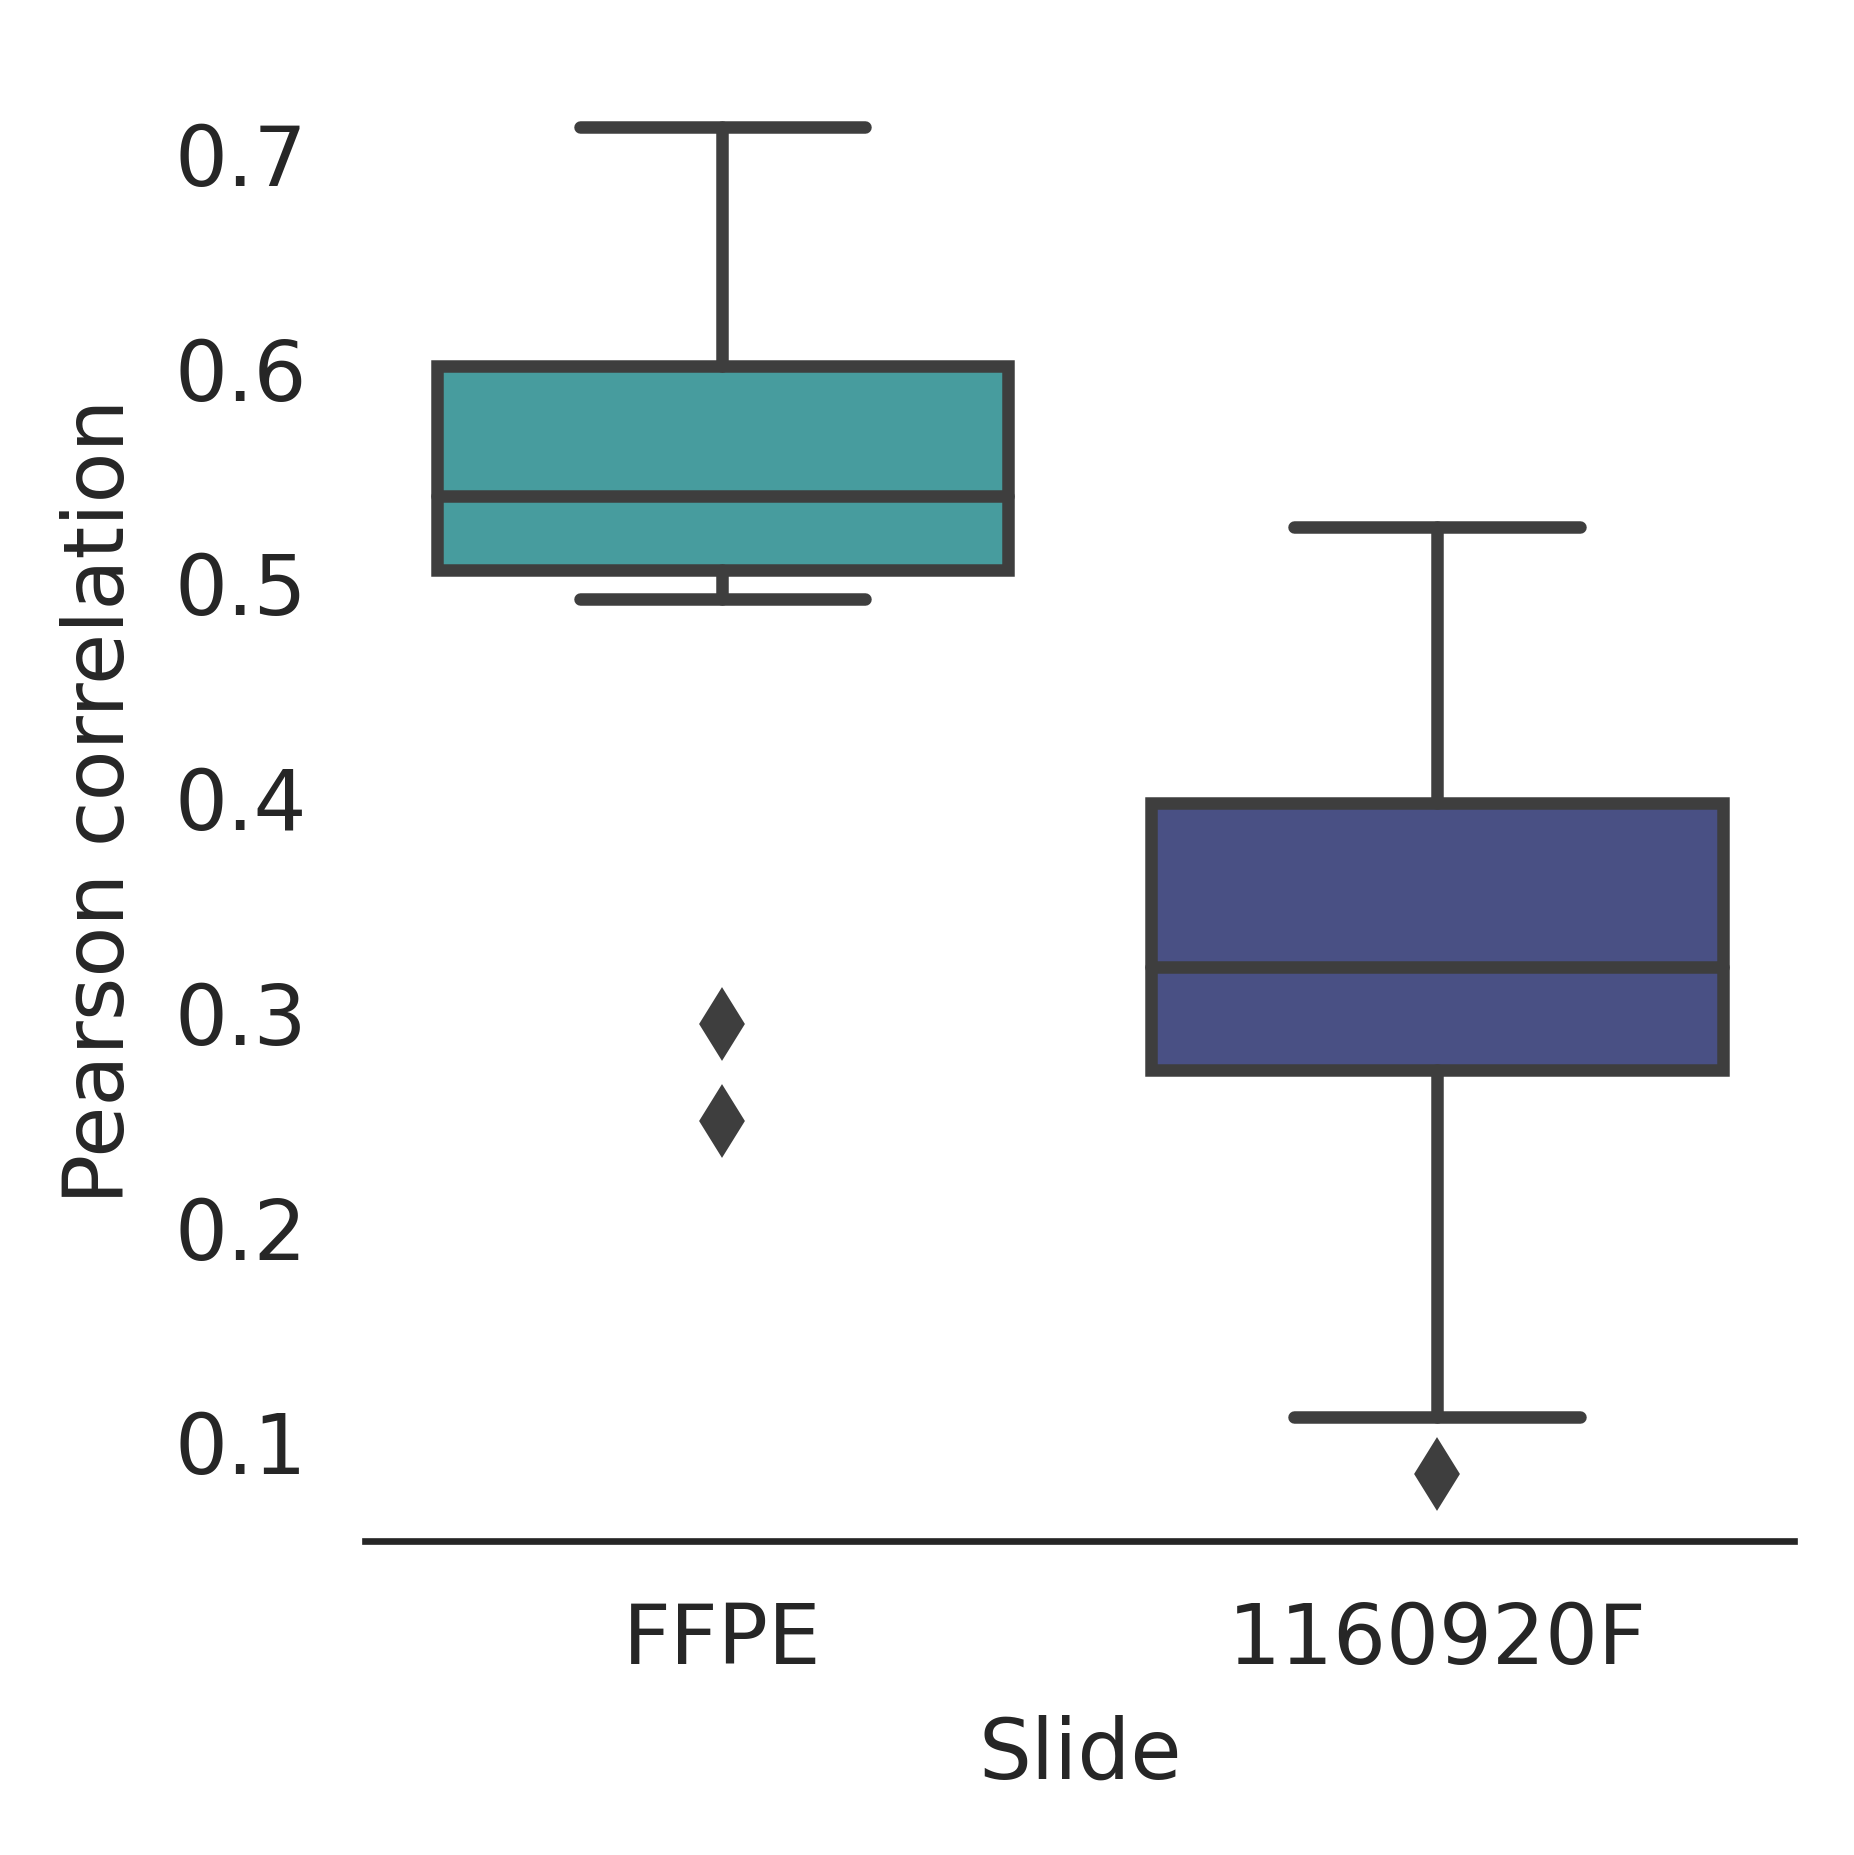

In [85]:
g = sns.catplot(
    data=df, kind="box",
    x="Slide", y="Pearson correlation", palette="mako_r", #alpha=0.8, height=6,
    height=3,
)
g.despine(left=True)
plt.show()

In [79]:
pred_adata = test_dataset_1_
test_dataset = test_dataset_1
df_ = pd.DataFrame()

for gene in pred_adata.var_names:
    test_dataset.obsm["gpd"] = gpd.GeoDataFrame(test_dataset.obs,
                                             geometry=gpd.points_from_xy(
                                                 test_dataset.obs.imagecol,
                                                 test_dataset.obs.imagerow))
    x = test_dataset.to_df()[gene].values
    y = pred_adata.to_df()[gene].values
    w = Queen.from_dataframe(test_dataset.obsm["gpd"])
    moran = Moran(y,w)
    moran_bv = Moran_BV(y, x, w)
    moran_loc = Moran_Local(y, w)
    moran_loc_bv = Moran_Local_BV(y, x, w)
    df_ = df_.append(pd.Series([gene, moran_bv.I, "FFPE"], index=["Gene", "Moran's I", "Slide"]),
                  ignore_index=True)

pred_adata = test_dataset_2_
test_dataset = test_dataset_2

for gene in pred_adata.var_names:
    test_dataset.obsm["gpd"] = gpd.GeoDataFrame(test_dataset.obs,
                                             geometry=gpd.points_from_xy(
                                                 test_dataset.obs.imagecol,
                                                 test_dataset.obs.imagerow))
    x = test_dataset.to_df()[gene].values
    y = pred_adata.to_df()[gene].values
    w = Queen.from_dataframe(test_dataset.obsm["gpd"])
    moran = Moran(y,w)
    moran_bv = Moran_BV(y, x, w)
    moran_loc = Moran_Local(y, w)
    moran_loc_bv = Moran_Local_BV(y, x, w)
    df_ = df_.append(pd.Series([gene, moran_bv.I, "1160920F"], index=["Gene", "Moran's I", "Slide"]),
                  ignore_index=True)

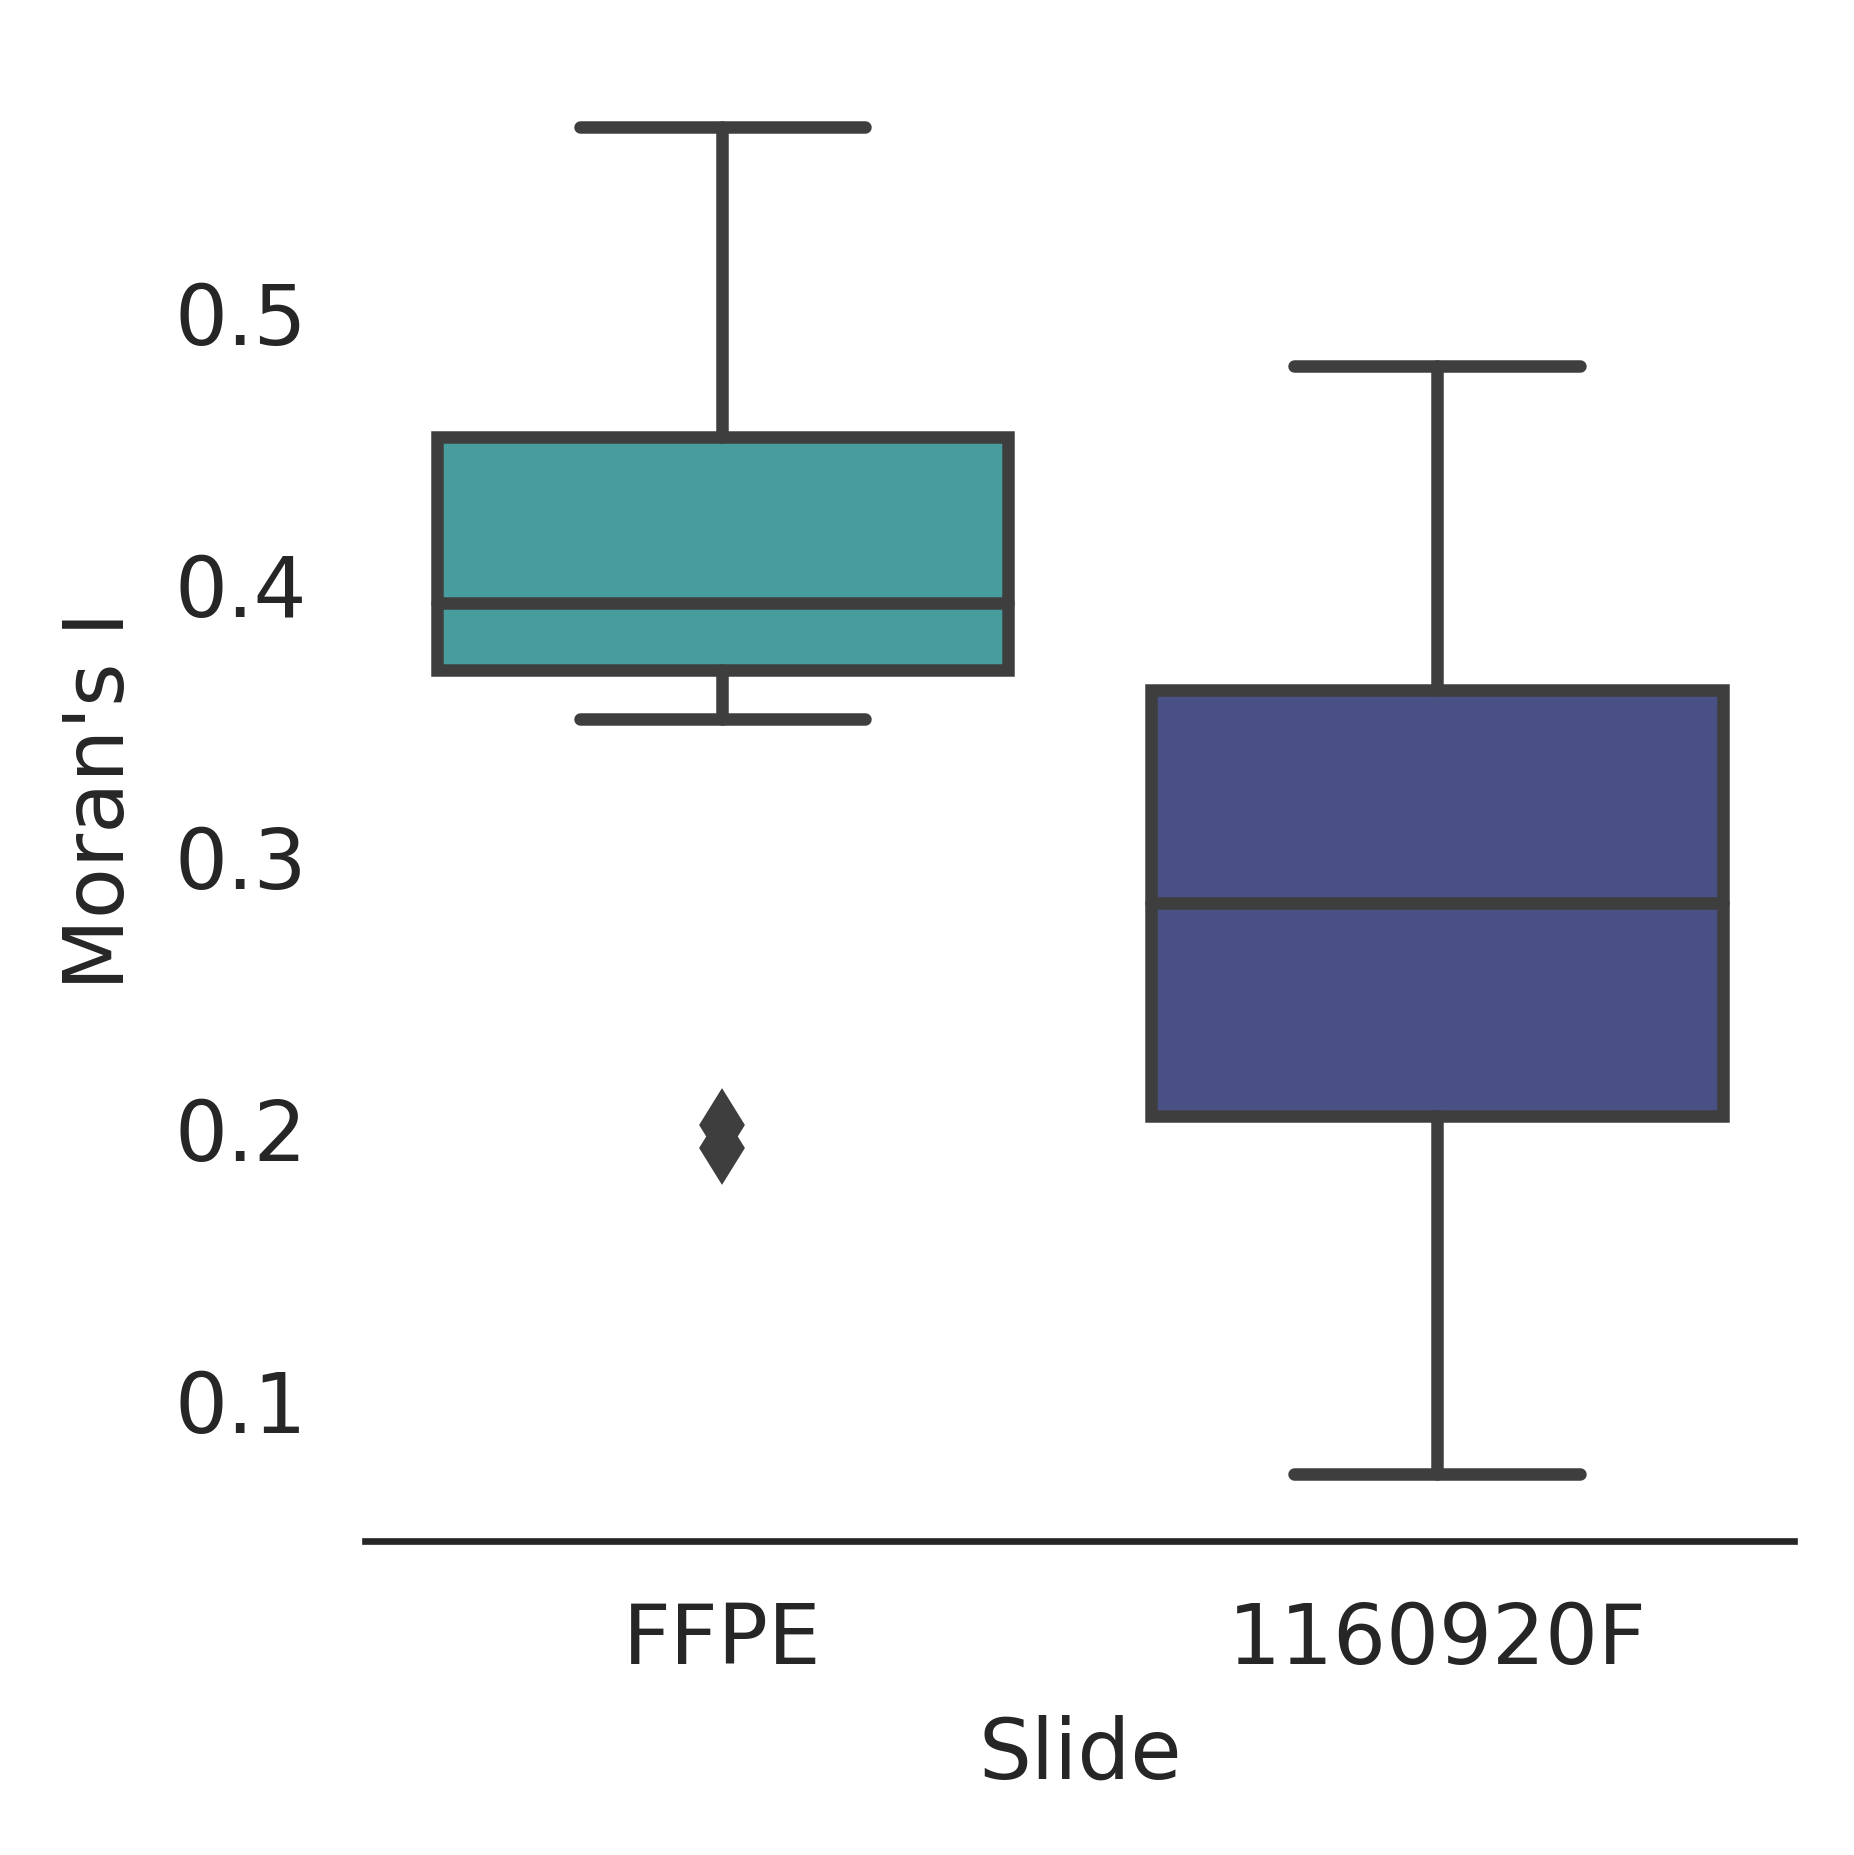

In [86]:
g = sns.catplot(
    data=df_, kind="box",
    x="Slide", y="Moran's I", palette="mako_r", #alpha=0.8, height=6,
    height=3,
)
g.despine(left=True)
plt.show()